## Load packages

In [3]:
using Trapz, Revise, Cuba, Interpolations, StatsPlots, IntervalSets, BAT, FileIO, LaTeXStrings, HypergeometricFunctions, SpecialFunctions, BenchmarkTools, Distributions, KernelDensity, DelimitedFiles, Memoize, NestedSamplers, JLD2, Roots, AbstractMCMC, Random, StatsBase

model = "GWTC3_lognormal2"
include("events.jl")
include("utils.jl")

LoadError: LoadError: ArgumentError: Cannot open 'backup/VT_1yr_m1m2_LIGO_O1.txt': not a file
in expression starting at /home/czc/projects/working/pbh/merger_history_gw190521/code/utils.jl:82

In [ ]:
h, ΩM, mc, σc, f = 0.674, 0.315, 15, 0.5, 1e-3
cosmo = LCDM(h, ΩM);
fpbh = 1e-3
log_fpbh = -3

-3

In [9]:
injections0 = readdlm("/home/czc/projects/working/LIGO_posterior/O1_O2_O3_det_frame_SNR9.txt");
injections_ini = Injection(injections0[:, 1], injections0[:, 2], injections0[:, 3], injections0[:, 4], injections0[:, 5], injections0[:, 6], 266152887, 1.9945205796549974);
injections = update_cut(injections_ini, 11, 0);

Selecting injections with SNR 11 and IFAR 100 yr.


In [10]:
R_density = Lognormal_R_Density(mc, σc, f)
R_density.mergerRateDensity(cosmo, 10, 30, 1)
cal_Nexp(injections, cosmo, R_density)

11431.851749907131

In [11]:
posts0 = [get_post(event) for event in GWTC3_events_BBH];
posts = [reduce_post(post, 200) for post in posts0];

In [12]:
post = posts[1];
lnLike_single_event(cosmo, R_density, post)
lnLike_events(cosmo, R_density, posts)
merger_rate(cosmo, R_density, 1e-10), merger_rate_1st(cosmo, R_density, 1e-10) + merger_rate_2nd(cosmo, R_density, 1e-10)

(7.859441418873882, 7.859441441550927)

In [13]:
function lnLike(mc, σc, log_fpbh)
    fpbh = 10.0^log_fpbh
    R_density = Lognormal_R_Density(mc, σc, fpbh)
    lnL0(injections, cosmo, R_density, posts)
end


lnLike (generic function with 1 method)

In [15]:
lnLike(mc, σc, log_fpbh)

-11817.961145312913

## Likelihood

In [16]:
@time lnLike(mc, σc, log_fpbh)

  0.299162 seconds (5.45 M allocations: 145.921 MiB, 5.06% gc time)


-11817.961145312913

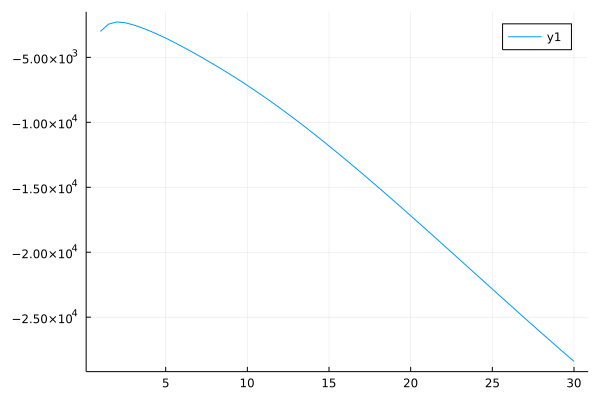

In [17]:
mcs = 1:0.5:30
lls = [lnLike(mc, σc, log_fpbh) for mc in mcs]
plot(mcs, lls)

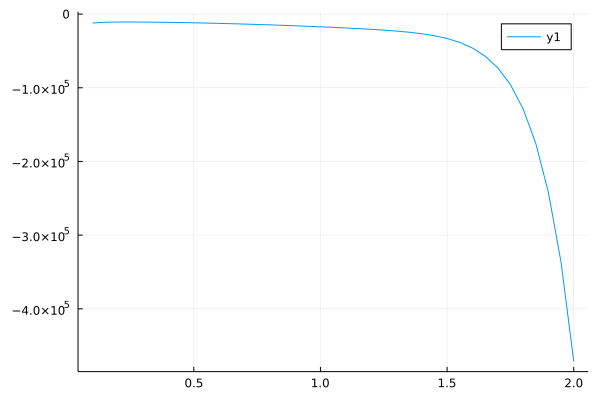

In [18]:
σcs = 0.1:0.05:2
lls = [lnLike(mc, σc, log_fpbh) for σc in σcs]
plot(σcs, lls)

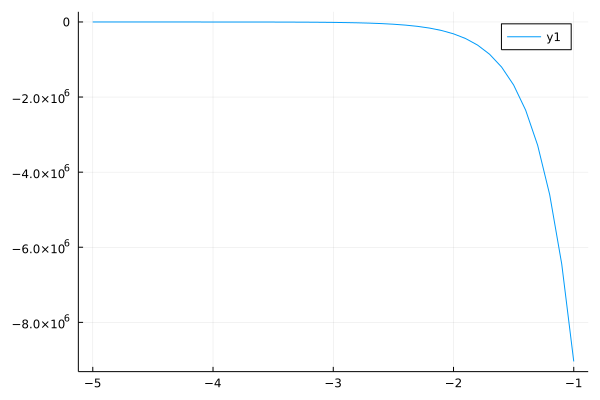

In [19]:
log_fpbhs = -5:0.1:-1
lls = [lnLike(mc, σc, log_fpbh) for log_fpbh in log_fpbhs]
plot(log_fpbhs, lls)

## Sampling

In [20]:
likelihood = ps -> LogDVal(lnLike(ps.mc, ps.σc, ps.log_fpbh))

prior = BAT.NamedTupleDist(
    mc=(5) .. (40),
    σc=(0.1) .. (2.0),
    log_fpbh=(-4) .. (-0.0)
)

posterior = PosteriorDensity(likelihood, prior);

In [21]:
true_par_values = (mc=mc, σc=σc, log_fpbh=-3)
@time likelihood(true_par_values)

  0.323596 seconds (5.45 M allocations: 146.271 MiB, 6.93% gc time, 2.86% compilation time)


LogDVal{Float64}(-11817.961145312913)

In [22]:
@time begin
    println("Start sampling.")

    burnin = MCMCMultiCycleBurnin(max_ncycles=1000)
    samples, chains = bat_sample(posterior, MCMCSampling(mcalg=MetropolisHastings(), nsteps=10^4, nchains=4, burnin=burnin))
end

save("backup/samples_$model.jld2", Dict("samples" => samples, "chains" => chains))
println(" ")
println("Finish sampling and save samples.")

Start sampling.


┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/algotypes/bat_default.jl:44
┌ Info: Using transform algorithm PriorSubstitution()
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/chain_pool_init.jl:56


┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/chain_pool_init.jl:173
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/multi_cycle_burnin.jl:35


┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/multi_cycle_burnin.jl:65


┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 1 tuned, 0 converged.
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/multi_cycle_burnin.jl:65


┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 1 tuned, 0 converged.
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/multi_cycle_burnin.jl:65


┌ Info: MCMC Tuning cycle 4 finished, 4 chains, 2 tuned, 0 converged.
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/multi_cycle_burnin.jl:65


┌ Info: MCMC Tuning cycle 5 finished, 4 chains, 3 tuned, 0 converged.
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/multi_cycle_burnin.jl:65


┌ Info: MCMC Tuning cycle 6 finished, 4 chains, 3 tuned, 0 converged.
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/multi_cycle_burnin.jl:65


┌ Info: MCMC Tuning cycle 7 finished, 4 chains, 3 tuned, 0 converged.
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/multi_cycle_burnin.jl:65


┌ Info: MCMC Tuning cycle 8 finished, 4 chains, 3 tuned, 0 converged.
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/multi_cycle_burnin.jl:65


┌ Info: MCMC Tuning cycle 9 finished, 4 chains, 3 tuned, 4 converged.
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/multi_cycle_burnin.jl:65


┌ Info: MCMC Tuning cycle 10 finished, 4 chains, 2 tuned, 4 converged.
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/multi_cycle_burnin.jl:65


┌ Info: MCMC Tuning cycle 11 finished, 4 chains, 3 tuned, 4 converged.
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/multi_cycle_burnin.jl:65


┌ Info: MCMC Tuning cycle 12 finished, 4 chains, 3 tuned, 4 converged.
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/multi_cycle_burnin.jl:65


┌ Info: MCMC Tuning cycle 13 finished, 4 chains, 3 tuned, 4 converged.
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/multi_cycle_burnin.jl:65


┌ Info: MCMC Tuning cycle 14 finished, 4 chains, 2 tuned, 4 converged.
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/multi_cycle_burnin.jl:65


┌ Info: MCMC Tuning cycle 15 finished, 4 chains, 2 tuned, 4 converged.
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/multi_cycle_burnin.jl:65


┌ Info: MCMC Tuning cycle 16 finished, 4 chains, 4 tuned, 4 converged.
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC tuning of 4 chains successful after 16 cycle(s).
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/multi_cycle_burnin.jl:71


74291.123366 seconds (3.81 T allocations: 97.278 TiB, 28.52% gc time, 0.01% compilation time: 1% of which was recompilation)


 
Finish sampling and save samples.


In [23]:
samples = load("backup/samples_$model.jld2")["samples"];

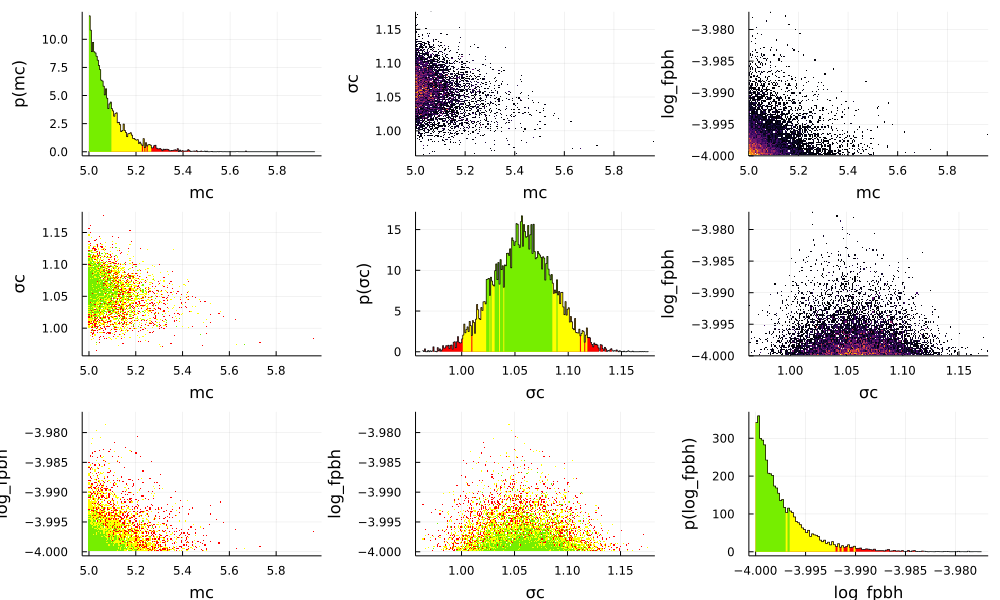

In [24]:
plot(samples)

In [25]:
# plot(
#     samples, :log_p3,
#     mean = true, std = true, globalmode = true, marginalmode = true,
#     nbins = 50, title = "Marginalized Distribution for y"
# )

In [26]:
sd = SampledDensity(posterior, samples)
display(sd)

BAT.jl - SampledDensity
──────────────────────────────

Sampling:
─────────────────────────
total number of samples:      10861
effective number of samples: (mc = 2221.7996900841613, σc = 2240.639268357291, log_fpbh = 1339.5670702001678)


Parameter estimates:
─────────────────────────
number of free parameters: 3

NamedTuple{(:parameter, :mean, :std, :global_mode, :marginal_mode), Tuple{Symbol, Float64, Float64, Float64, Float64}}[(parameter = :mc, mean = 5.081472246162373, std = 0.07959937962557535, global_mode = 5.002512549264293, marginal_mode = 5.0024999999999995), (parameter = :σc, mean = 1.0579879368834935, std = 0.028352112607166108, global_mode = 1.0615346555311596, marginal_mode = 1.0565), (parameter = :log_fpbh, mean = -3.997255205225453, std = 0.0027750263745311052, global_mode = -3.9999844263896187, marginal_mode = -3.9997)]


Covariance matrix:
─────────────────────────
3×3 Named Matrix{Float64}
  cov ╲  │           mc            σc      log_fpbh
─────────┼───────────────

In [27]:
get_post(para, samples) = [a[para] for a in samples.v]

get_post (generic function with 1 method)

In [29]:
mc_posts = get_post(:mc, samples)
σc_posts = get_post(:σc, samples)
log_fpbh_posts = get_post(:log_fpbh, samples)

fpbh_posts = 10 .^ log_fpbh_posts;

In [30]:
R_posts = zeros(length(mc_posts))
Threads.@threads for i in 1:length(R_posts)
    R_posts[i] = merger_rate(mc_posts[i], σc_posts[i], fpbh_posts[i])
end

save("backup/R_posts_$model.jld2", Dict("samples" => R_posts))
R_posts = load("backup/R_posts_$model.jld2")["samples"];

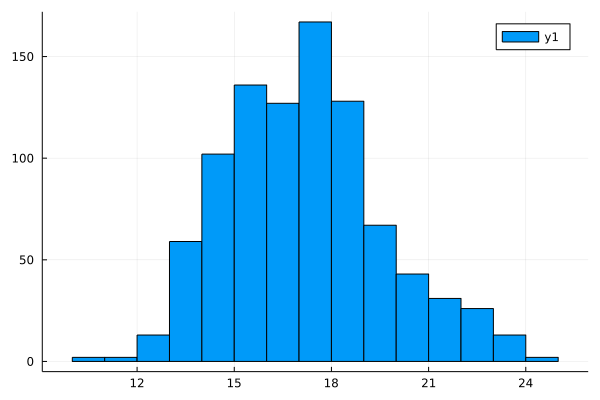

In [31]:
histogram(mc_posts)

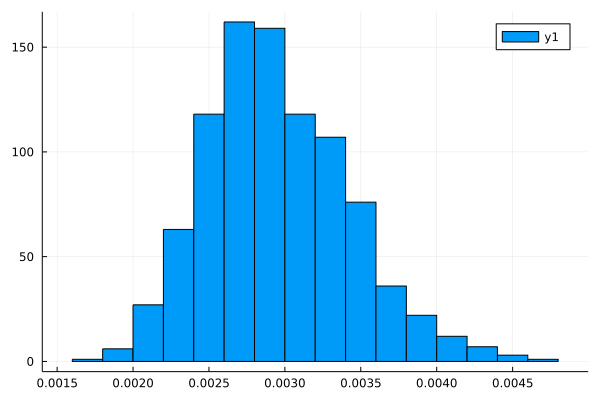

In [32]:
histogram(fpbh_posts)

In [33]:
get_quantile(posts) = quantile(posts, [0.05, 0.5, 0.95])

get_quantile (generic function with 1 method)